# Depth Mapping from Normal Mapping with Averaged Integrals from Rotated Discrete Origin Functions

This algorithm estimates a 3d integral with the normal mapping. First the directional gradients of the normals in x- and y-direction are calculated. They are then used to calculate the integrated values by a cumulative sum (Riemann sum). This process is repeated with differently rotated versions of the gradient mapping to average the values and reduce errors as a cumulative sum alone is very prone for subsequent errors.

## Imports


In [22]:
import numpy as np
import cv2 as cv
from scipy.ndimage import rotate
from skimage import io
from math import sin, cos, radians, sqrt, ceil, floor
from threading import Thread, Lock
from typing import List, Tuple
from matplotlib import pyplot as plt


$ \displaystyle
\int f(x,y) \approx \sum_{\theta = 0}^{2\pi} R_{z(-\theta)} \cdot \sum_{x=0}^{x_{max}} f(x, y) \cdot R_{z(\theta)}
$

In [23]:
def estimate_depth_map(
    normal_map_uri: str,
    normal_map_is_open_gl: bool = True,
    target_quality_percent: float = 1,
    max_thread_count: int = 1,
) -> np.ndarray:
    """Estimates a depth mapping from a given normal mapping.

    Parameters
    ----------
    normal_map_path : str
        The URI or simple filepath to the normal mapping.
    normal_map_is_open_gl : bool, optional
        Set to `False` if the normal map is in DirectX format with flipped green/y channel, by default `True`.
    target_quality_percent : float, optional
        The target quality of the depth mapping defined how many iterations of integrations are performed, by default `1`.
    max_thread_count : int, optional
        The maximum number of threads used to calculate the depth mapping, by default `1`.

    Returns
    -------
    np.ndarray
        The depth mapping as image array.
    """

    normal_map = io.imread(normal_map_uri).astype(np.float64)
    width, height, _ = normal_map.shape
    normal_map = normal_map[:, :, :3]  # Remove alpha channel if present.
    normal_map = ((normal_map / 255) - 0.5) * 2  # Transform from [0, 255] to [-1, 1].
    normals = normal_map.reshape((width * height, 3))  # Reshape to vector array.
    normals /= np.linalg.norm(normals)  # Normalize the normals in case they aren't.
    normals[:, 1] *= 1 if normal_map_is_open_gl else -1  # Invert green if not ogl.

    gradient_map = np.empty((width, height, 2))
    gradient_map[:, :, 0] = (-normals[:, 0] / normals[:, 2]).reshape((width, height))
    gradient_map[:, :, 1] = (normals[:, 1] / normals[:, 2]).reshape((width, height))

    diagonal_length: int = ceil(sqrt(width**2 + height**2))
    padding = (
        ceil((diagonal_length - width) / 2),
        ceil((diagonal_length - height) / 2),
    )
    gradient_map = np.pad(gradient_map, (padding, padding, (0, 0)))
    gradient_map = gradient_map[
        gradient_map.shape[0] - diagonal_length :,
        gradient_map.shape[1] - diagonal_length :,
        :,
    ]

    isotropic_integral = np.zeros((diagonal_length, diagonal_length))
    isotropic_integral_lock: Lock = Lock()

    def integrate_anisotropic(angles: List[float]):
        for angle in angles:

            x_factor: float = cos(radians(angle))
            y_factor: float = sin(radians(angle))

            anisotropic_gradient_map = rotate(
                gradient_map[:, :, 0] * x_factor + gradient_map[:, :, 1] * y_factor,
                angle,
                reshape=False,
            )

            anisotropic_integral = rotate(
                np.cumsum(anisotropic_gradient_map, axis=1),
                -angle,
                reshape=False,
            )

            isotropic_integral_lock.acquire()
            isotropic_integral[~np.isnan(anisotropic_integral)] += anisotropic_integral[
                ~np.isnan(anisotropic_integral)
            ]
            isotropic_integral_lock.release()

    max_thread_count = max(max_thread_count, 1)
    target_quality_percent = min(target_quality_percent, 100)
    target_iteration_count: float = (width * 2 + height * 2) * (
        target_quality_percent / 100
    )
    target_iteration_count = max(target_iteration_count, 1)
    anisotropic_integral_threads: List[Thread] = []
    angle_per_thread: float = 360 / max_thread_count
    iterations_per_thread: int = max(
        round(target_iteration_count / max_thread_count), 1
    )

    for thread_id in range(0, max_thread_count + 1):
        angle_start_point: float = thread_id * angle_per_thread
        angle_stop_point: float = (thread_id + 1) * angle_per_thread

        angles = np.linspace(
            angle_start_point,
            angle_stop_point,
            iterations_per_thread,
            endpoint=False,
        )

        thread = Thread(target=integrate_anisotropic, args=(angles,))
        thread.start()
        anisotropic_integral_threads.append(thread)

    for thread in anisotropic_integral_threads:
        thread.join()

    depth_map = isotropic_integral[
        floor((diagonal_length - width) / 2) : floor((diagonal_length + width) / 2),
        floor((diagonal_length - height) / 2) : floor((diagonal_length + height) / 2),
    ]

    # Normalizes depth values to [0, 1].
    depth_map -= np.min(depth_map)
    depth_map /= np.max(depth_map)

    depth_map *= pow(2, 8) - 1  # Transform from [0, 1] to [0, 255].

    return depth_map


## Example usage

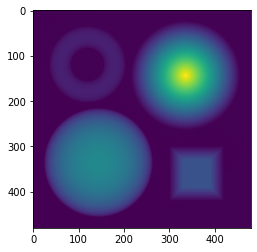

In [24]:
NORMAL_MAP_PATH: str = (
    "https://raw.githubusercontent.com/YertleTurtleGit/depth-from-normals/main/normal_mapping.png"
)
DEPTH_MAP_PATH: str = "depth_mapping.png"

depth_map_image: np.ndarray = estimate_depth_map(
    NORMAL_MAP_PATH,
    normal_map_is_open_gl=True,
    target_quality_percent=1,
    max_thread_count=2,
)

cv.imwrite(DEPTH_MAP_PATH, depth_map_image)
plt.imshow(depth_map_image)
